In [11]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(
    "/home/jupyter/igor_repos/exploration/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/collect_mi_results.csv"
)

In [12]:
# Rename columns for clarity
df = df.rename(columns={"algorithm": "method", "signal": "metric"})
df

,dataset,size,quality,method,metric,seed,mi_value,umis_per_cell
0,PBMC,100,0.001235,Geneformer,celltype.l3,42,0.53784,10
1,PBMC,100,0.001235,Geneformer,celltype.l3,2701,0.39424,10
2,PBMC,100,0.001235,Geneformer,protein_counts,42,0.71425,10
3,PBMC,100,0.001235,Geneformer,protein_counts,2701,0.63226,10
4,PBMC,100,0.001235,PCA,celltype.l3,42,0.30650,10
...,...,...,...,...,...,...,...,...
4839,shendure,10000000,1.000000,PCA,author_day,42,1.14821,2500
4840,shendure,10000000,1.000000,PCA,author_day,1404,1.09550,2500
4841,shendure,10000000,1.000000,RandomProjection,author_day,42,0.62163,2500
4842,shendure,10000000,1.000000,RandomProjection,author_day,1404,0.62163,2500


### fitting noise scaling laws

/var/tmp/ipykernel_3349364/3761603959.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_results = pd.concat(all_fit_results, ignore_index=True)


,dataset,size,quality,method,metric,seed,mi_value,umis_per_cell,fitted_mi_value,A_info,B_info,A_info_err,B_info_err,y_info,y_info_lower
0,PBMC,100,0.001235,Geneformer,celltype.l3,42,0.53784,10,0.459889,0.006016,0.100563,0.0008,0.010258,0.068023,-0.068023
1,PBMC,100,0.001235,Geneformer,celltype.l3,2701,0.39424,10,0.459889,0.006016,0.100563,0.0008,0.010258,0.068023,-0.068023
2,PBMC,100,0.002598,Geneformer,celltype.l3,42,0.71172,21,0.733065,0.006016,0.100563,0.0008,0.010258,0.085571,-0.085571
3,PBMC,100,0.002598,Geneformer,celltype.l3,2701,0.76171,21,0.733065,0.006016,0.100563,0.0008,0.010258,0.085571,-0.085571
4,PBMC,100,0.005468,Geneformer,celltype.l3,42,1.08677,44,1.050387,0.006016,0.100563,0.0008,0.010258,0.089559,-0.089559


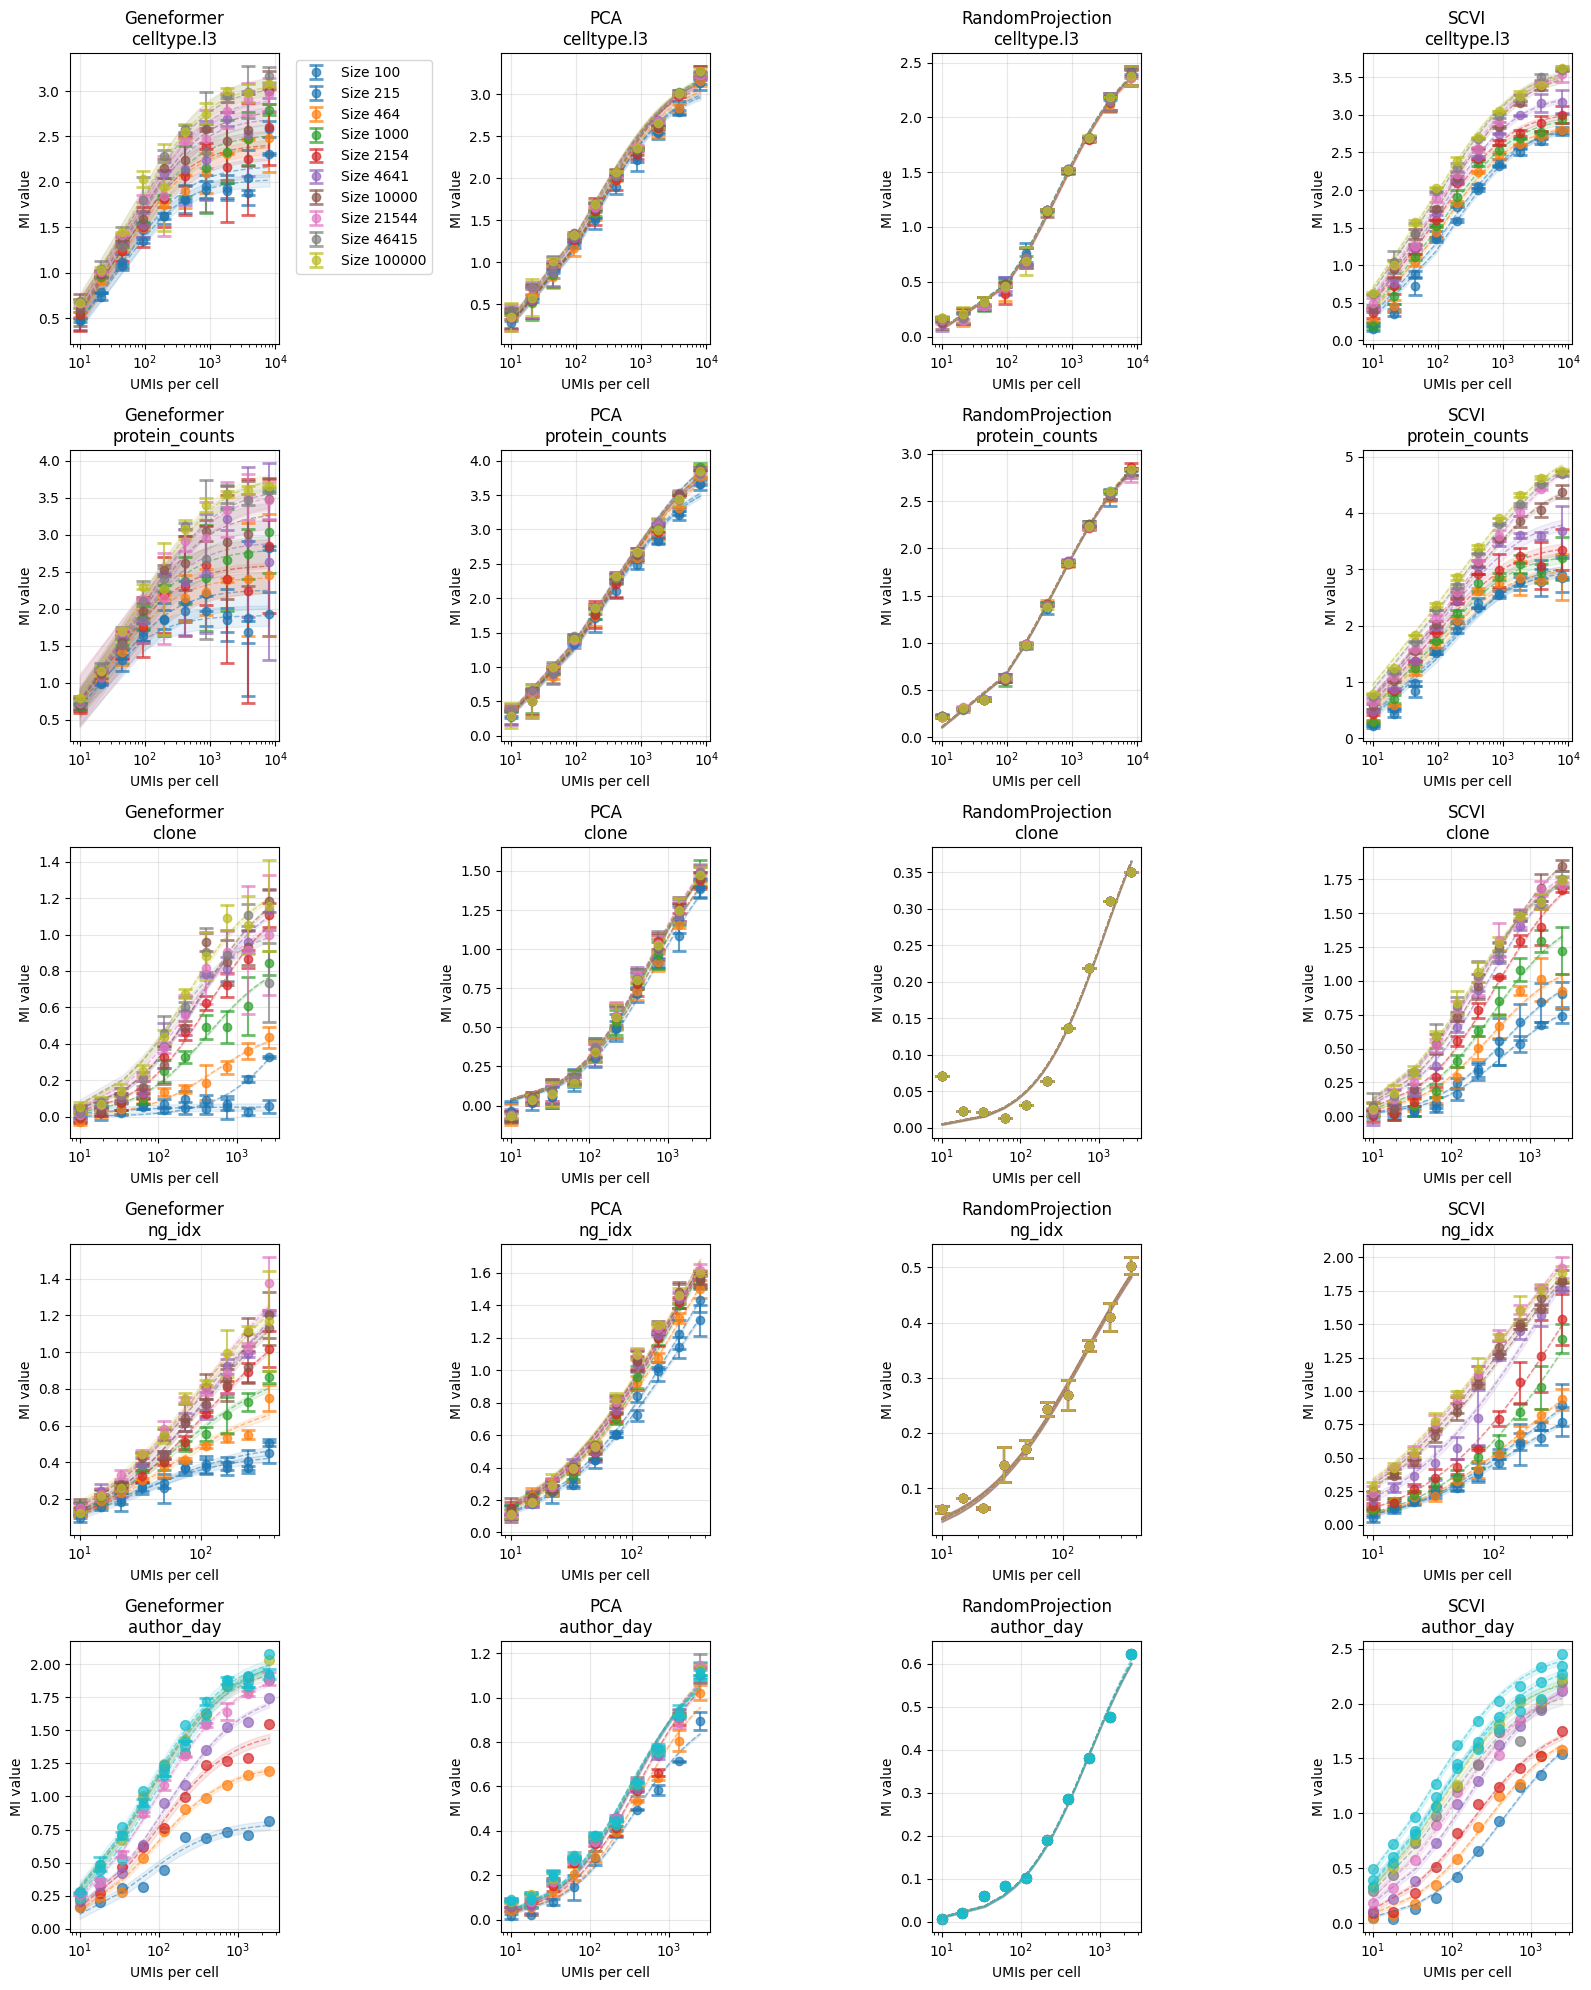

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model, Parameters


def info_scaling(x, A_info, B_info):
    """
    Information scaling function: I(x) = 0.5 * log2((x*B_info + 1)/(1 + A_info*x))
    """
    return 0.5 * np.log2((x * B_info + 1) / (1 + A_info * x))


def fit_noise_scaling_model(u_values, mi_values):
    """
    Fit the noise scaling model to data and return A_info and B_info with uncertainties.

    Parameters:
    u_values: array of UMI per cell values
    mi_values: array of mutual information values

    Returns:
    dict with A_info, B_info and their uncertainties, plus fit success status
    """

    # Define the noise scaling function for fitting
    def info_scaling_local(x, A_info, B_info):
        """
        Information scaling function: I(x) = 0.5 * log2((x*B_info + 1)/(1 + A_info*x))
        """
        return 0.5 * np.log2((x * B_info + 1) / (1 + A_info * x))

    # Create lmfit model
    model = Model(info_scaling_local)

    # Set up parameters with initial values and bounds
    params = model.make_params(A_info=1e-2, B_info=1e-2)  # initial guesses
    params["A_info"].min = 0  # set bounds
    params["B_info"].min = 0

    # Fit the curve
    try:
        result = model.fit(mi_values, params, x=u_values)
        A_info = result.params["A_info"].value
        B_info = result.params["B_info"].value
        A_info_err = result.params["A_info"].stderr
        B_info_err = result.params["B_info"].stderr

        # Compute uncertainty bands
        x_fit = u_values
        y_info = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_info_lower = -y_info

        return {
            "fit_success": True,
            "result": result,
            "A_info": A_info,
            "B_info": B_info,
            "A_info_err": A_info_err,
            "B_info_err": B_info_err,
            "y_info": y_info,
            "y_info_lower": y_info_lower,
        }

    except Exception as e:
        return {
            "fit_success": False,
            "result": None,
            "A_info": np.nan,
            "B_info": np.nan,
            "A_info_err": np.nan,
            "B_info_err": np.nan,
            "y_info": np.nan,
            "y_info_lower": np.nan,
        }


# Create a loop to iterate over different datasets, methods, metrics and cell sizes
import os

# Get unique combinations of dataset, size, method, and metric
unique_combinations = df.groupby(["dataset", "size", "method", "metric"]).size().reset_index(name="count")

# Initialize list to store all results
all_fit_results = []

# Loop through each combination
for idx, row in unique_combinations.iterrows():
    dataset = row["dataset"]
    size = row["size"]
    method = row["method"]
    metric = row["metric"]

    # Filter data for current combination
    filtered_data = df[
        (df["dataset"] == dataset) & (df["size"] == size) & (df["method"] == method) & (df["metric"] == metric)
    ]

    # Skip if not enough data points
    if len(filtered_data) < 3:
        continue

    # Extract data for fitting
    u_values = filtered_data["umis_per_cell"].values
    mi_values = filtered_data["mi_value"].values

    # Fit the model
    fit_results = fit_noise_scaling_model(u_values, mi_values)

    if fit_results["fit_success"]:
        # Calculate fitted MI values for the original data points
        fitted_mi_values = info_scaling(u_values, fit_results["A_info"], fit_results["B_info"])

        # Add new columns to the filtered data
        filtered_data_with_fits = filtered_data.copy()
        filtered_data_with_fits["fitted_mi_value"] = fitted_mi_values
        filtered_data_with_fits["A_info"] = fit_results["A_info"]
        filtered_data_with_fits["B_info"] = fit_results["B_info"]
        filtered_data_with_fits["A_info_err"] = fit_results["A_info_err"]
        filtered_data_with_fits["B_info_err"] = fit_results["B_info_err"]
        filtered_data_with_fits["y_info"] = fit_results["y_info"]
        filtered_data_with_fits["y_info_lower"] = fit_results["y_info_lower"]

        # Append to results list
        all_fit_results.append(filtered_data_with_fits)

# Combine all results into a single DataFrame
if all_fit_results:
    combined_results = pd.concat(all_fit_results, ignore_index=True)

    # Save to CSV
    output_filename = "/home/jupyter/igor_repos/exploration/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/fitted_data_with_results.csv"
    combined_results.to_csv(output_filename, index=False)

    # Display first few rows
    display(combined_results.head())

import matplotlib.pyplot as plt
import numpy as np

# Create the plot
if all_fit_results:
    # Get unique combinations of metric and method
    metrics = combined_results["metric"].unique()
    methods = combined_results["method"].unique()

    # Create subplots
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(4 * len(methods), 4 * len(metrics)))

    # Handle case where there's only one metric or method
    if len(metrics) == 1 and len(methods) == 1:
        axes = np.array([[axes]])
    elif len(metrics) == 1:
        axes = axes.reshape(1, -1)
    elif len(methods) == 1:
        axes = axes.reshape(-1, 1)

    # Color scheme for different sizes
    sizes = sorted(combined_results["size"].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(sizes)))
    size_color_map = dict(zip(sizes, colors))
    for i, metric in enumerate(metrics):
        for j, method in enumerate(methods):
            ax = axes[i, j]

            # Filter data for this metric and method combination
            subset = combined_results[(combined_results["metric"] == metric) & (combined_results["method"] == method)]

            if len(subset) > 0:
                # Plot points for each size
                for size in sizes:
                    size_data = subset[subset["size"] == size]
                    if len(size_data) > 0:
                        # Group by umis_per_cell to handle multiple seeds
                        grouped = size_data.groupby("umis_per_cell")

                        x_vals = []
                        y_means = []
                        y_stds = []

                        for umis, group in grouped:
                            x_vals.append(umis)
                            mi_values = group["mi_value"]
                            y_means.append(mi_values.mean())
                            y_stds.append(mi_values.std() if len(mi_values) > 1 else 0)

                        x_vals = np.array(x_vals)
                        y_means = np.array(y_means)
                        y_stds = np.array(y_stds)

                        # Plot error bars if there are multiple seeds, otherwise scatter points
                        if np.any(y_stds > 0):
                            ax.errorbar(
                                x_vals,
                                y_means,
                                yerr=y_stds,
                                color=size_color_map[size],
                                fmt="o",
                                capsize=5,
                                capthick=2,
                                alpha=0.7,
                                markersize=6,
                                label=f"Size {size}",
                            )
                        else:
                            ax.scatter(
                                x_vals,
                                y_means,
                                color=size_color_map[size],
                                alpha=0.7,
                                s=50,
                                label=f"Size {size}",
                            )
                        # Plot fitted line for this size with uncertainty bands
                        u_range = np.linspace(size_data["umis_per_cell"].min(), size_data["umis_per_cell"].max(), 100)
                        # Use the fitted parameters (they should be the same for all points with same size/metric/method)
                        A_info = size_data["A_info"].iloc[0]
                        B_info = size_data["B_info"].iloc[0]
                        y_info = size_data["y_info"].iloc[0]
                        y_info_lower = size_data["y_info_lower"].iloc[0]

                        # Calculate fitted curve
                        fitted_curve = info_scaling(u_range, A_info, B_info)

                        # Plot uncertainty bands
                        ax.fill_between(
                            u_range,
                            fitted_curve + y_info,
                            fitted_curve + y_info_lower,
                            color=size_color_map[size],
                            alpha=0.1,
                        )

                        # Plot fitted line
                        ax.plot(u_range, fitted_curve, color=size_color_map[size], linestyle="--", lw=1, alpha=0.5)

                ax.set_xlabel("UMIs per cell")
                ax.set_ylabel("MI value")
                ax.set_title(f"{method}\n{metric}")
                ax.set_xscale("log")
                ax.grid(True, alpha=0.3)

                # Add legend only to the first subplot
                if i == 0 and j == 0:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            else:
                ax.set_title(f"{method}\n{metric}\n(No data)")

    plt.tight_layout()
    plt.show()

### fitting cell scaling laws

All fits successful!


,dataset,size,quality,method,metric,seed,mi_value,umis_per_cell,fitted_mi_value,A_info,...,y_info,y_info_lower,A_cell_fit,B_cell_fit,C_cell_fit,A_cell_err,B_cell_err,C_cell_err,y_cell_upper,y_cell_lower
0,PBMC,100,0.001235,Geneformer,celltype.l3,42,0.53784,10,0.459889,0.006016,...,0.068023,-0.068023,10.000006,0.638826,0.636438,24.227778,0.389216,0.034592,0.758721,-0.758721
1,PBMC,100,0.001235,Geneformer,celltype.l3,2701,0.39424,10,0.459889,0.006016,...,0.068023,-0.068023,10.000006,0.638826,0.636438,24.227778,0.389216,0.034592,0.758721,-0.758721
2,PBMC,100,0.002598,Geneformer,celltype.l3,42,0.71172,21,0.733065,0.006016,...,0.085571,-0.085571,12.728572,0.561908,1.034728,6.040733,0.126586,0.020007,0.054538,-0.054538
3,PBMC,100,0.002598,Geneformer,celltype.l3,2701,0.76171,21,0.733065,0.006016,...,0.085571,-0.085571,12.728572,0.561908,1.034728,6.040733,0.126586,0.020007,0.054538,-0.054538
4,PBMC,100,0.005468,Geneformer,celltype.l3,42,1.08677,44,1.050387,0.006016,...,0.089559,-0.089559,10.000003,0.471476,1.391374,8.585509,0.255915,0.056438,0.473666,-0.473666


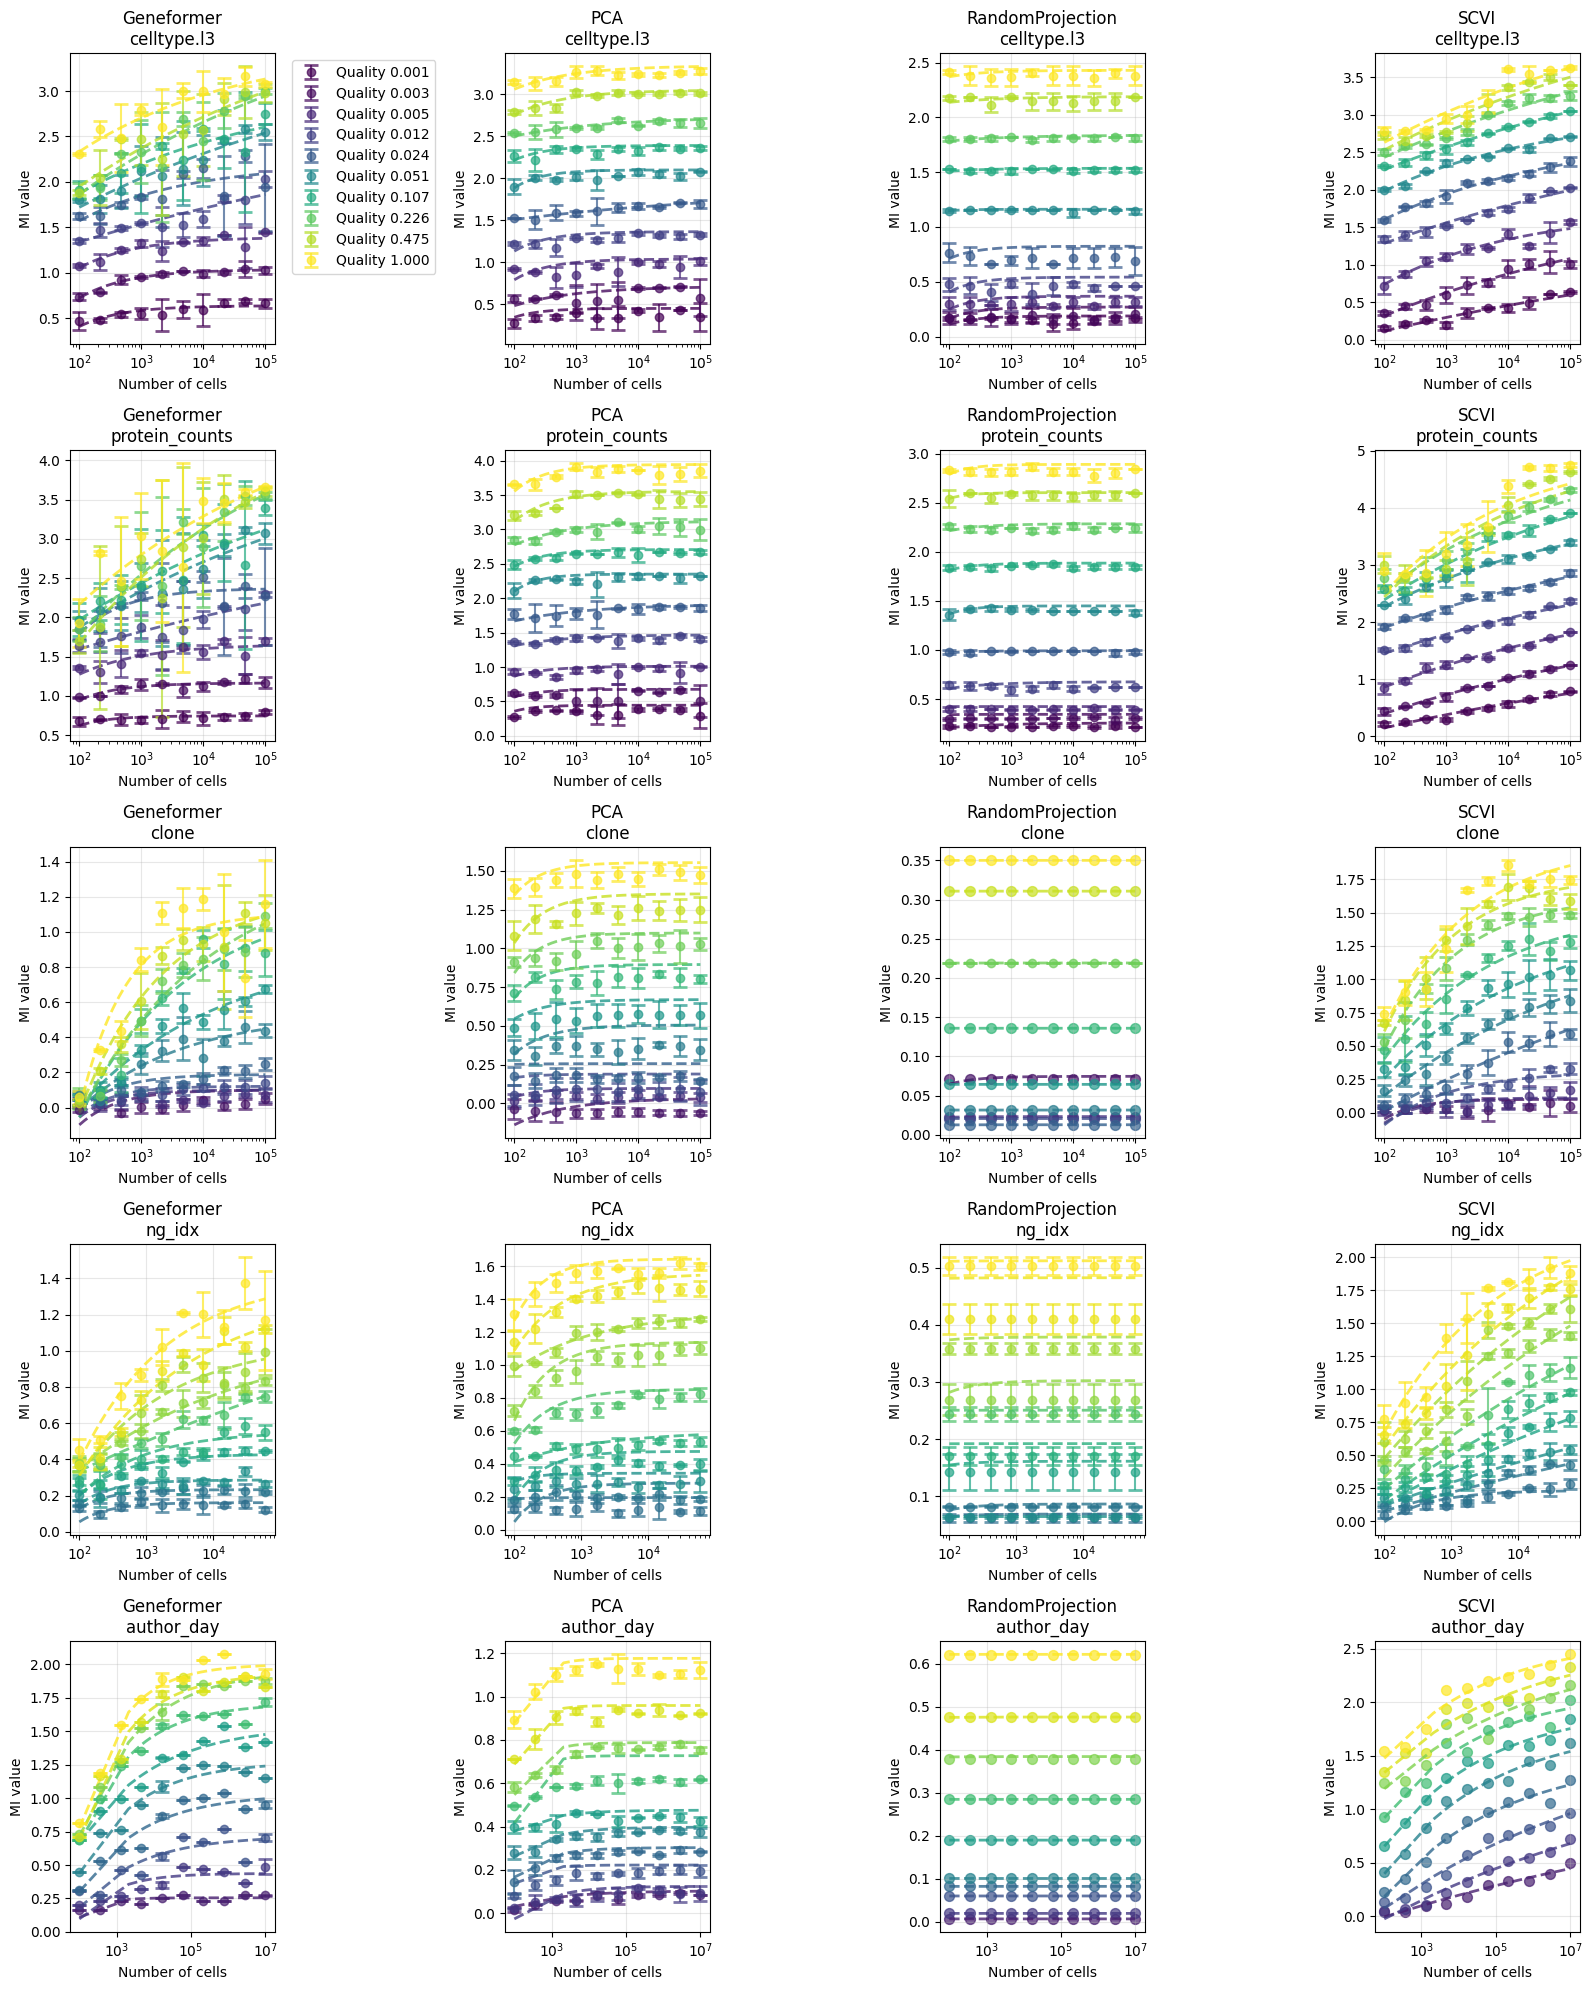

Saved combined results with fits to 'combined_mi_results_with_fits.csv'
Shape: (4844, 23)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model, Parameters


def cell_number_scaling(x, A_cell, B_cell, C_cell):
    """
    Cell number scaling function: I(x) = C_cell - (x / A_cell) ** (-B_cell)
    """
    return C_cell - (x / A_cell) ** (-B_cell)


def fit_cell_number_scaling_model(cell_values, mi_values):
    """
    Fit the cell number scaling model to data and return parameters with uncertainties.

    Parameters:
    cell_values: array of cell number values
    mi_values: array of mutual information values

    Returns:
    dict with A_cell, B_cell, C_cell and their uncertainties, plus fit success status
    """

    # Define the cell number scaling function for fitting
    def cell_number_scaling_local(x, A_cell, B_cell, C_cell):
        """
        Cell number scaling function: I(x) = C_cell - (x / A_cell) ** (-B_cell)
        """
        # Add protection against division by zero and invalid operations
        with np.errstate(divide="ignore", invalid="ignore"):
            result = np.where(x > 0, C_cell - (x / A_cell) ** (-B_cell), np.nan)
        return result

    # Create lmfit model
    model = Model(cell_number_scaling_local)

    # Set up parameters with initial values and bounds
    if method in ["PCA", "RandomProjection"]:
        params = model.make_params(
            A_cell=dict(value=10**4, min=1e-6),
            B_cell=dict(value=1, min=1e-3),
            C_cell=dict(value=1, min=mi_values.max(), max=mi_values.max() * 1.5),
        )
    else:  # SCVI or Geneformer
        # Set up parameters with initial values and bounds based on the image
        params = model.make_params(A_cell=10**4, B_cell=0.5, C_cell=2.5)  # initial guesses from image
        params["A_cell"].min = 10  # set bounds
        params["A_cell"].max = 10**6
        params["B_cell"].min = 0.01
        params["B_cell"].max = 2.0
        params["C_cell"].min = 0.1
        params["C_cell"].max = 5.0

    # Fit the curve
    try:
        result = model.fit(mi_values, params, x=cell_values)
        A_cell_val = result.params["A_cell"].value
        B_cell_val = result.params["B_cell"].value
        C_cell_val = result.params["C_cell"].value
        A_cell_err = result.params["A_cell"].stderr if result.params["A_cell"].stderr is not None else np.nan
        B_cell_err = result.params["B_cell"].stderr if result.params["B_cell"].stderr is not None else np.nan
        C_cell_err = result.params["C_cell"].stderr if result.params["C_cell"].stderr is not None else np.nan

        # Compute uncertainty bands
        x_fit = cell_values
        y_cell_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_cell_lower = -y_cell_upper

        return {
            "A_cell": A_cell_val,
            "B_cell": B_cell_val,
            "C_cell": C_cell_val,
            "A_cell_err": A_cell_err,
            "B_cell_err": B_cell_err,
            "C_cell_err": C_cell_err,
            "fit_success": True,
            "result": result,
            "y_cell_upper": y_cell_upper,
            "y_cell_lower": y_cell_lower,
        }

    except Exception as e:
        return {
            "A_cell": np.nan,
            "B_cell": np.nan,
            "C_cell": np.nan,
            "A_cell_err": np.nan,
            "B_cell_err": np.nan,
            "C_cell_err": np.nan,
            "fit_success": False,
            "result": None,
            "y_cell_upper": np.nan,
            "y_cell_lower": np.nan,
        }


# Create a loop to iterate over different datasets, methods, metrics and qualities
import os

# Load the existing combined results from the original file
original_path = "/home/jupyter/igor_repos/exploration/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/fitted_data_with_results.csv"
combined_results = pd.read_csv(original_path)

# Get unique combinations of dataset, method, metric, and quality
unique_combinations = df.groupby(["dataset", "method", "metric", "quality"]).size().reset_index(name="count")

# Initialize columns for cell scaling parameters if they don't exist
cell_scaling_columns = [
    "A_cell_fit",
    "B_cell_fit",
    "C_cell_fit",
    "A_cell_err",
    "B_cell_err",
    "C_cell_err",
    "y_cell_upper",
    "y_cell_lower",
]
for col in cell_scaling_columns:
    if col not in combined_results.columns:
        combined_results[col] = np.nan

# Loop through each combination
failed_fits = []
for idx, row in unique_combinations.iterrows():
    dataset = row["dataset"]
    method = row["method"]
    metric = row["metric"]
    quality = row["quality"]

    # Filter data for current combination
    filtered_data = df[
        (df["dataset"] == dataset) & (df["method"] == method) & (df["metric"] == metric) & (df["quality"] == quality)
    ]

    # Skip if not enough data points
    if len(filtered_data) < 3:
        continue

    # Extract data for fitting
    cell_values = filtered_data["size"].values
    mi_values = filtered_data["mi_value"].values

    # Fit the model
    fit_results = fit_cell_number_scaling_model(cell_values, mi_values)

    if fit_results["fit_success"]:
        # Find matching rows in combined_results and update with cell scaling parameters
        mask = (
            (combined_results["dataset"] == dataset)
            & (combined_results["method"] == method)
            & (combined_results["metric"] == metric)
            & (combined_results["quality"] == quality)
        )

        # Update the parameters for all matching rows
        combined_results.loc[mask, "A_cell_fit"] = fit_results["A_cell"]
        combined_results.loc[mask, "B_cell_fit"] = fit_results["B_cell"]
        combined_results.loc[mask, "C_cell_fit"] = fit_results["C_cell"]
        combined_results.loc[mask, "A_cell_err"] = fit_results["A_cell_err"]
        combined_results.loc[mask, "B_cell_err"] = fit_results["B_cell_err"]
        combined_results.loc[mask, "C_cell_err"] = fit_results["C_cell_err"]

        # For uncertainty bands, we need to calculate them for each specific cell value
        for idx_row in combined_results[mask].index:
            size = combined_results.loc[idx_row, "size"]
            # Calculate uncertainty for this specific cell count
            try:
                y_upper = fit_results["result"].eval_uncertainty(
                    params=fit_results["result"].params, x=np.array([size]), sigma=2
                )[0]
                combined_results.loc[idx_row, "y_cell_upper"] = y_upper
                combined_results.loc[idx_row, "y_cell_lower"] = -y_upper
            except:
                combined_results.loc[idx_row, "y_cell_upper"] = np.nan
                combined_results.loc[idx_row, "y_cell_lower"] = np.nan
    else:
        # Record failed fit
        failed_fits.append(f"{dataset}/{method}/{metric}/quality={quality:.3f}")
        print(f"Fitting failed for: {dataset}, {method}, {metric}, quality={quality:.3f}")

# Print summary of failed fits
if failed_fits:
    print(f"\nTotal failed fits: {len(failed_fits)}")
    print("Failed combinations:")
    for failed in failed_fits:
        print(f"  - {failed}")
else:
    print("All fits successful!")

# Save the updated results back to the original path
combined_results.to_csv(original_path, index=False)

# Create a subset for visualization
cell_scaling_results = combined_results[combined_results["A_cell_fit"].notna()].copy()

# Display first few rows of the results with cell scaling fits
display(cell_scaling_results.head())

import matplotlib.pyplot as plt
import numpy as np

# Flag to control whether to show uncertainty bands on the plot
show_uncertainty = False

# Create the plot
if len(cell_scaling_results) > 0:
    # Get unique combinations of metric and method
    metrics = cell_scaling_results["metric"].unique()
    methods = cell_scaling_results["method"].unique()

    # Create subplots with methods as columns and metrics as rows
    fig, axes = plt.subplots(len(metrics), len(methods), figsize=(4 * len(methods), 4 * len(metrics)))

    # Handle case where there's only one metric or method
    if len(metrics) == 1 and len(methods) == 1:
        axes = np.array([[axes]])
    elif len(metrics) == 1:
        axes = axes.reshape(1, -1)
    elif len(methods) == 1:
        axes = axes.reshape(-1, 1)

    # Color scheme for different qualities
    qualities = sorted(cell_scaling_results["quality"].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(qualities)))
    quality_color_map = dict(zip(qualities, colors))

    for i, metric in enumerate(metrics):
        for j, method in enumerate(methods):
            ax = axes[i, j]

            # Filter data for this metric and method combination
            subset = cell_scaling_results[
                (cell_scaling_results["metric"] == metric) & (cell_scaling_results["method"] == method)
            ]

            if len(subset) > 0:
                # Plot points for each quality
                for quality in qualities:
                    quality_data = subset[subset["quality"] == quality]
                    if len(quality_data) > 0:
                        # Group by size (cell number) to handle multiple seeds
                        grouped = quality_data.groupby("size")

                        x_vals = []
                        y_means = []
                        y_stds = []

                        for size, group in grouped:
                            x_vals.append(size)
                            mi_values = group["mi_value"]
                            y_means.append(mi_values.mean())
                            y_stds.append(mi_values.std() if len(mi_values) > 1 else 0)

                        x_vals = np.array(x_vals)
                        y_means = np.array(y_means)
                        y_stds = np.array(y_stds)

                        # Plot error bars if there are multiple seeds, otherwise scatter points
                        if np.any(y_stds > 0):
                            ax.errorbar(
                                x_vals,
                                y_means,
                                yerr=y_stds,
                                color=quality_color_map[quality],
                                fmt="o",
                                capsize=5,
                                capthick=2,
                                alpha=0.7,
                                markersize=6,
                                label=f"Quality {quality:.3f}",
                            )
                        else:
                            ax.scatter(
                                x_vals,
                                y_means,
                                color=quality_color_map[quality],
                                alpha=0.7,
                                s=50,
                                label=f"Quality {quality:.3f}",
                            )

                        # Plot fitted line for this quality with uncertainty bands
                        cell_range = np.linspace(quality_data["size"].min(), quality_data["size"].max(), 5000)
                        # Use the fitted parameters (they should be the same for all points with same quality/metric/method)
                        A_cell_fit = quality_data["A_cell_fit"].iloc[0]
                        B_cell_fit = quality_data["B_cell_fit"].iloc[0]
                        C_cell_fit = quality_data["C_cell_fit"].iloc[0]

                        # Calculate fitted curve
                        fitted_curve = cell_number_scaling(cell_range, A_cell_fit, B_cell_fit, C_cell_fit)

                        # Plot uncertainty bands only if flag is enabled
                        if show_uncertainty:
                            # For uncertainty bands, we'd need to recalculate for the range
                            # This is simplified for now
                            y_cell_upper = (
                                quality_data["y_cell_upper"].iloc[0]
                                if not pd.isna(quality_data["y_cell_upper"].iloc[0])
                                else 0
                            )
                            ax.fill_between(
                                cell_range,
                                fitted_curve + y_cell_upper,
                                fitted_curve - y_cell_upper,
                                color=quality_color_map[quality],
                                alpha=0.1,
                            )

                        # Plot fitted line
                        ax.plot(
                            cell_range, fitted_curve, color=quality_color_map[quality], linestyle="--", lw=2, alpha=0.8
                        )

                ax.set_xlabel("Number of cells")
                ax.set_ylabel("MI value")
                ax.set_title(f"{method}\n{metric}")
                ax.set_xscale("log")
                ax.grid(True, alpha=0.3)

                # Add legend only to the first subplot
                if i == 0 and j == 0:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            else:
                ax.set_title(f"{method}\n{metric}\n(No data)")

    plt.tight_layout()
    plt.show()

# Save the combined results with fits to CSV
combined_results.to_csv("combined_mi_results_with_fits.csv", index=False)
print(f"Saved combined results with fits to 'combined_mi_results_with_fits.csv'")
print(f"Shape: {combined_results.shape}")

In [23]:
combined_results.to_csv("combined_mi_results_with_fits_final.csv", index=False)

### fix final table for restuls